<a href="https://colab.research.google.com/github/PeterTKovacs/mosquito_recoginition/blob/main/APRO_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from PIL import Image
from pathlib import Path
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import os
from os.path import isfile, join
import random

import numpy as np
import torch
import torchvision

from torchvision import transforms
from tqdm import tqdm

In [11]:
class BaseLine:
    def __init__(self,
        input_images_path_ = 'drive/My Drive/AML2020/images',
        csv_ = 'drive/My Drive/AML2020/train.csv',
        input_path_ = 'drive/My Drive/AML2020',
        train_path_ = 'drive/My Drive/AML2020/train4',
        test_path_ = 'drive/My Drive/AML2020/test',
        valid_path_ = 'drive/My Drive/AML2020/validation',
                no_=4):
        
        import torch
        import torchvision
        
        self.input_images_path = input_images_path_
        self.csv = csv_
        
        self.input_path = input_path_
        self.train_path = train_path_
        self.test_path = test_path_
        self.valid_path = valid_path_
        self.no=no_


    
    def folder_generator(self):
        import pandas as pd
        import logging as log
        import os
        
        csv_labels = pd.read_csv(self.csv)
        
        #images_paths = list(csv_labels['file'])
        images_paths = csv_labels['file']
        images_paths = [path.replace('images/', '') for path in images_paths]
        
        #images_labels = list(csv_labels['is_tiger'])
        images_labels = csv_labels['is_tiger']
        counter = 1
        
        tiger_path_train = os.path.join(self.train_path, 'tiger')
        tiger1_path_train = os.path.join(self.train_path, 'tiger1')
        tiger2_path_train = os.path.join(self.train_path, 'tiger2')
        tiger3_path_train = os.path.join(self.train_path, 'tiger3')
        tiger4_path_train = os.path.join(self.train_path, 'tiger4')
        not_tiger_path_train = os.path.join(self.train_path, 'not_tiger')

        
        tiger_path_val = os.path.join(self.valid_path, 'tiger')
        not_tiger_path_val = os.path.join(self.valid_path, 'not_tiger')
        
        test_unknown_path = os.path.join(self.test_path, 'unknown')
        
        os.mkdir(self.train_path)
        os.mkdir(tiger_path_train)
        os.mkdir(not_tiger_path_train)

        os.mkdir(self.valid_path)
        os.mkdir(tiger_path_val)
        os.mkdir(not_tiger_path_val)
        
        os.mkdir(self.test_path)
        os.mkdir(test_unknown_path)
        
        #Handling Train Images
        print('###Handling Train Images')
        for image_name, image_label in zip(images_paths, images_labels):
            print('Copying image: {}, with label: {}'.format(image_name, image_label))    
            if image_name.split('_')[0] == 'train' and counter % 5 != 0:
                if image_label == 1:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(tiger_path_train, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, tiger_path_train))
                else:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(not_tiger_path_train, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, not_tiger_path_train))
            else:
                if image_label == 1:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(tiger_path_val, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, tiger_path_val))
                else:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(not_tiger_path_val, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, not_tiger_path_val))
            
    
    def data_loader(self):
        import torch
        import torchvision
        from torchvision import transforms
        #ImageFolder
        #Augementation for train and valid images
        train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        val_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(), 
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        train_dataset = torchvision.datasets.ImageFolder(self.train_path, train_transforms)
        #train_dataset = torchvision.datasets.ImageFolder(train_data, train_transforms)
        validation_dataset = torchvision.datasets.ImageFolder(self.valid_path, val_transforms)
        
        #DataLoader
        batch_size = 16
        train_dataloader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size
        )

        validation_dataloader = torch.utils.data.DataLoader(
            validation_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size
        )
        print(len(train_dataset), len(validation_dataset))
        print(len(train_dataloader), len(validation_dataloader))
        return train_dataloader, validation_dataloader
    
    def show_images(self, train_dataloader):
        import numpy as np
        import matplotlib.pyplot as plt
        X_batch, y_batch = next(iter(train_dataloader))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([[0.229, 0.224, 0.225]])
        for index in range(5):
            plt.title(y_batch[index])
            plt.imshow(X_batch[index].permute(1,2,0).numpy() * std + mean, )
            plt.show()
    
    def model(self):
        from torchvision import models
        import torch
        model = models.resnet152(pretrained=True)
        
        
        #Disable grad for all conv layers
        for param in model.parameters():
            param.requires_grad = False 

        model.fc = torch.nn.Linear(model.fc.in_features, 2)
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        loss = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(),amsgrad=True, lr=3.0e-4)
       
        
        #Declay LR by a factor of 0.1 every 5th epoch
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.4)
        return model, loss, optimizer, scheduler, device
    
    def train_model(self, model, loss, optimizer, scheduler, train, validation, device, num_epochs):
        import torch
        from tqdm import tqdm

        best_accuracy=-1
        best_path='best'+str(self.no)+'.pth'

        for epoch in range(num_epochs):
            print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    dataloader = train
                    scheduler.step()
                    
                    model.train()  # Set model to training mode
                else:
                    dataloader = validation
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.
                running_acc = 0.
                running_acc_tiger = 0.
                running_acc_not_tiger = 0.

                # Iterate over data.
                for inputs, labels in tqdm(dataloader):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    # forward and backward
                    with torch.set_grad_enabled(phase == 'train'):
                        preds = model(inputs)
                        loss_value = loss(preds, labels)
                        preds_class = preds.argmax(dim=1)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss_value.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss_value.item()
                    running_acc += (preds_class == labels.data).float().mean()
                    running_acc_tiger += (preds_class == 1).float().mean()
                    running_acc_not_tiger += (preds_class == 0).float().mean()

                epoch_loss = running_loss / len(dataloader)
                epoch_acc = running_acc / len(dataloader)
                epoch_acc_tiger = running_acc_tiger / len(dataloader)
                epoch_acc_not_tiger = running_acc_not_tiger / len(dataloader)



                print('{} Loss: {:.4f} Acc: {:.4f} Tiger Acc: {:.4f} Not Tiger Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_acc_tiger, epoch_acc_not_tiger), flush=True)

                if epoch_acc>best_accuracy and phase=='val' :
                    
                    self.create_checkpoint(model,optimizer,best_path,epoch,loss_value)
                    best_accuracy=epoch_acc
        
        
        self.load_from_checkpoint(model,optimizer,best_path)

        return model

    def create_checkpoint(self,model,optimizer,path,epoch,loss):
        
        # basically copied from the tutorial, 
        # https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

        torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss,
              }, path)
        
    def load_from_checkpoint(self,model,optimizer,path):
        
        # basically copied from the tutorial, 
        # https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html
        
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        print('reloading best model of epoch %d, loss %f'%(checkpoint['epoch'],checkpoint['loss']))

    
    def run(self,num_ep=10):
        #Processing data
        #Job = BaseLine()
        #Job.folder_generator()
        #train_dataloader, validation_dataloader = Job.data_loader('drive/My Drive/AML2020/train0')
        #train_dataloader1, validation_dataloader1 = Job.data_loader('drive/My Drive/AML2020/train1')
        #train_dataloader2, validation_dataloader2 = Job.data_loader('drive/My Drive/AML2020/train2')
        #train_dataloader3, validation_dataloader3 = Job.data_loader('drive/My Drive/AML2020/train3')
        #train_dataloader4, validation_dataloader4 = Job.data_loader('drive/My Drive/AML2020/train4')
        #Job.show_images(train_dataloader)
        
        #Define model
        #model, loss, optimizer, scheduler, device = Job.model()
        #print(model, loss, optimizer, scheduler)
        #Train model 
        #trained_model = Job.train_model(model, loss, optimizer, scheduler, train_dataloader, validation_dataloader, device, num_epochs=num_ep)
        #trained_model1 = Job.train_model(model, loss, optimizer, scheduler, train_dataloader1, validation_dataloader1, device, num_epochs=num_ep)
        #trained_model2 = Job.train_model(model, loss, optimizer, scheduler, train_dataloader2, validation_dataloader2, device, num_epochs=num_ep)
        #trained_model3 = Job.train_model(model, loss, optimizer, scheduler, train_dataloader3, validation_dataloader3, device, num_epochs=num_ep)
        #trained_model4 = Job.train_model(model, loss, optimizer, scheduler, train_dataloader4, validation_dataloader4, device, num_epochs=num_ep)
        #return trained_model, trained_model1, trained_model2, trained_model3, trained_model4
        #return trained_model



        train_dataloader, validation_dataloader = self.data_loader()
        
        #Define model
        
        model, loss, optimizer, scheduler, device = self.model()

        #Train model 
        
        trained_model = self.train_model(model, loss, optimizer, scheduler, train_dataloader, validation_dataloader,
                                         device, num_epochs=num_ep)
        return trained_model

In [12]:
model = BaseLine().run()

1132 855
71 54
Epoch 0/9:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 71/71 [00:41<00:00,  1.72it/s]

train Loss: 0.6235 Acc: 0.6617 Tiger Acc: 0.4921 Not Tiger Acc: 0.5079



100%|██████████| 54/54 [00:08<00:00,  6.02it/s]

val Loss: 0.4971 Acc: 0.8275 Tiger Acc: 0.7488 Not Tiger Acc: 0.2512


Epoch 1/9:


100%|██████████| 71/71 [00:11<00:00,  6.04it/s]

train Loss: 0.5163 Acc: 0.7717 Tiger Acc: 0.5073 Not Tiger Acc: 0.4927



100%|██████████| 54/54 [00:08<00:00,  6.08it/s]

val Loss: 0.4431 Acc: 0.8275 Tiger Acc: 0.7303 Not Tiger Acc: 0.2697
Epoch 2/9:



100%|██████████| 71/71 [00:11<00:00,  6.15it/s]

train Loss: 0.5221 Acc: 0.7303 Tiger Acc: 0.5062 Not Tiger Acc: 0.4938



100%|██████████| 54/54 [00:08<00:00,  6.13it/s]

val Loss: 0.3903 Acc: 0.8480 Tiger Acc: 0.7594 Not Tiger Acc: 0.2406


Epoch 3/9:


100%|██████████| 71/71 [00:11<00:00,  6.21it/s]

train Loss: 0.4525 Acc: 0.7946 Tiger Acc: 0.5021 Not Tiger Acc: 0.4979



100%|██████████| 54/54 [00:08<00:00,  6.08it/s]

val Loss: 0.3553 Acc: 0.8562 Tiger Acc: 0.7798 Not Tiger Acc: 0.2202


Epoch 4/9:


100%|██████████| 71/71 [00:11<00:00,  6.11it/s]

train Loss: 0.4305 Acc: 0.8148 Tiger Acc: 0.4927 Not Tiger Acc: 0.5073



100%|██████████| 54/54 [00:08<00:00,  6.17it/s]

val Loss: 0.3504 Acc: 0.8581 Tiger Acc: 0.7763 Not Tiger Acc: 0.2237


Epoch 5/9:


100%|██████████| 71/71 [00:11<00:00,  6.00it/s]

train Loss: 0.4127 Acc: 0.8292 Tiger Acc: 0.4883 Not Tiger Acc: 0.5117



100%|██████████| 54/54 [00:08<00:00,  6.02it/s]

val Loss: 0.3648 Acc: 0.8515 Tiger Acc: 0.7574 Not Tiger Acc: 0.2426
Epoch 6/9:



100%|██████████| 71/71 [00:11<00:00,  6.13it/s]

train Loss: 0.4252 Acc: 0.8060 Tiger Acc: 0.4979 Not Tiger Acc: 0.5021



100%|██████████| 54/54 [00:08<00:00,  6.01it/s]

val Loss: 0.3649 Acc: 0.8484 Tiger Acc: 0.7497 Not Tiger Acc: 0.2503
Epoch 7/9:



100%|██████████| 71/71 [00:11<00:00,  6.07it/s]

train Loss: 0.4103 Acc: 0.8187 Tiger Acc: 0.4950 Not Tiger Acc: 0.5050



100%|██████████| 54/54 [00:08<00:00,  6.06it/s]

val Loss: 0.3598 Acc: 0.8504 Tiger Acc: 0.7586 Not Tiger Acc: 0.2414
Epoch 8/9:



100%|██████████| 71/71 [00:11<00:00,  6.09it/s]

train Loss: 0.4163 Acc: 0.8069 Tiger Acc: 0.4903 Not Tiger Acc: 0.5097



100%|██████████| 54/54 [00:09<00:00,  5.97it/s]

val Loss: 0.4070 Acc: 0.8275 Tiger Acc: 0.7103 Not Tiger Acc: 0.2897
Epoch 9/9:



100%|██████████| 71/71 [00:11<00:00,  6.07it/s]

train Loss: 0.4050 Acc: 0.8260 Tiger Acc: 0.5044 Not Tiger Acc: 0.4956



100%|██████████| 54/54 [00:08<00:00,  6.03it/s]

val Loss: 0.3426 Acc: 0.8608 Tiger Acc: 0.7728 Not Tiger Acc: 0.2272


reloading best model of epoch 9, loss 0.327450


In [13]:
def model_(n,basedir='drive/My Drive/AML2020/'):
    
    
    
    model=BaseLine(
    train_path_=os.path.join(basedir,'train'+str(n)),
    valid_path_=os.path.join(basedir,'validation'),
    test_path_=os.path.join(basedir,'test'),
    no_=n)
    
    return model

In [14]:
models={}
for i in range(5):
    m=model_(i)
    trained_m=m.run(num_ep=0)
    models[i]=trained_m

1136 855
71 54
reloading best model of epoch 1, loss 0.413348
1132 855
71 54
reloading best model of epoch 0, loss 0.327840
1132 855
71 54
reloading best model of epoch 1, loss 0.426961
1132 855
71 54
reloading best model of epoch 3, loss 0.318388
1132 855
71 54
reloading best model of epoch 9, loss 0.327450


In [15]:
import pandas as pd
import pickle

def softmax(tensor):
    
    z=np.sum(np.exp(np.asarray(tensor)))
    
    return np.exp(np.asarray(tensor))/z


def confidency(preds):
    
    confidencies=[]
    
    for pic in range(preds.shape[0]):
        
        confidencies.append(softmax(preds[pic,:])[1]) # guess that this is the tiger probability
        
    return confidencies

In [16]:
#test_tiger_names_all=os.listdir('drive/My Drive/AML2020/validation/tiger')
test_other_names=os.listdir('drive/My Drive/AML2020/validation/not_tiger')
test_tiger_names=random.sample(os.listdir('drive/My Drive/AML2020/validation/tiger'),len(test_other_names))

batch_size=10
counter=0
to_batch=[]
results={}

val_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(), 
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

for id_,model in models.items():
    results[id_]={}
    model.eval()

for pic in test_other_names:
    to_batch.append((pic,val_transforms(Image.open('drive/My Drive/AML2020/validation/not_tiger/'+pic))))
    counter+=1
    
    if counter==batch_size:
        
        batch=torch.cat([(item[1].reshape(-1,3,224,224)).cuda() for item in to_batch ])
        
        for id_,model in models.items():
            
            conf=confidency(model(batch).cpu().detach().numpy())
            
            for idx,item in enumerate(to_batch):
            
                results[id_][item[0]]=conf[idx]
                
        counter=0
        to_batch=[]
        
for pic in test_tiger_names:
    to_batch.append((pic,val_transforms(Image.open('drive/My Drive/AML2020/validation/tiger/'+pic).convert('RGB'))))
    counter+=1
    
    if counter==batch_size:
        
        batch=torch.cat([(item[1].reshape(-1,3,224,224)).cuda() for item in to_batch ])
        
        for id_,model in models.items():
            
            conf=confidency(model(batch).cpu().detach().numpy())
            
            for idx,item in enumerate(to_batch):
            
                results[id_][item[0]]=conf[idx]
                
        counter=0
        to_batch=[]
    
            
if len(to_batch)>0: #some pics remained unevaluated
    
    batch=torch.cat([(item[1].reshape(-1,3,224,224)).cuda() for item in to_batch ])
        
    for id_,model in models.items():

        conf=confidency(model(batch).cpu().detach().numpy())

        for idx,item in enumerate(to_batch):

            results[id_][item[0]]=conf[idx]

    counter=0
    to_batch=[]

In [17]:
import copy

In [18]:
rr=copy.deepcopy(results)

In [19]:
for idx,model in models.items():
    for key,value in rr[idx].items():
        rr[idx][key]=list([value,])

In [20]:
pd.DataFrame.from_dict(rr[0])

,train_14.png,train_24.png,train_49.png,train_104.png,train_199.png,train_244.png,train_249.png,train_314.png,train_364.png,train_384.png,train_394.png,train_424.png,train_474.png,train_479.png,train_529.png,train_534.png,train_539.png,train_659.png,train_719.png,train_724.png,train_789.png,train_834.png,train_869.png,train_1004.png,train_1029.png,train_1034.png,train_1079.png,train_1084.png,train_1109.png,train_1124.png,train_1134.png,train_1139.png,train_1149.png,train_1179.png,train_1189.png,train_1229.png,train_1294.png,train_1299.png,train_1309.png,train_1339.png,...,train_3529.png,train_3254.png,train_3069.png,train_2279.png,train_1969.png,train_389.png,train_909.png,train_319.png,train_1319.png,train_3789.png,train_1964.png,train_1749.png,train_809.png,train_1039.png,train_1269.png,train_334.png,train_3039.png,train_2759.png,train_64.png,train_1854.png,train_2104.png,train_2374.png,train_354.png,train_3869.png,train_1834.png,train_2769.png,train_664.png,train_969.png,train_2254.png,train_1569.png,train_3164.png,train_3769.png,train_2639.png,train_669.png,train_3284.png,train_114.png,train_3484.png,train_1599.png,train_559.png,train_3604.png
0,0.321682,0.272577,0.47895,0.73412,0.454799,0.300852,0.44797,0.632022,0.214687,0.41628,0.318279,0.658559,0.565169,0.597355,0.66286,0.390485,0.533042,0.455886,0.512667,0.42909,0.490204,0.458703,0.41283,0.590615,0.275955,0.497062,0.401471,0.554731,0.275605,0.329288,0.289217,0.345265,0.358797,0.190883,0.269066,0.705226,0.800927,0.781056,0.388212,0.751998,...,0.810085,0.530151,0.749466,0.809851,0.637587,0.490916,0.882961,0.734355,0.686453,0.468105,0.742985,0.840924,0.88109,0.908864,0.734443,0.809612,0.902583,0.721046,0.696815,0.830402,0.832728,0.835908,0.818141,0.62454,0.68871,0.64001,0.881034,0.708,0.822211,0.379919,0.630172,0.729037,0.895639,0.291278,0.62864,0.708667,0.693401,0.87011,0.853622,0.85504


In [21]:
tabular_res=pd.concat([pd.DataFrame.from_dict(rr[i]) for i in range(5)])

In [22]:
tabular_res

,train_14.png,train_24.png,train_49.png,train_104.png,train_199.png,train_244.png,train_249.png,train_314.png,train_364.png,train_384.png,train_394.png,train_424.png,train_474.png,train_479.png,train_529.png,train_534.png,train_539.png,train_659.png,train_719.png,train_724.png,train_789.png,train_834.png,train_869.png,train_1004.png,train_1029.png,train_1034.png,train_1079.png,train_1084.png,train_1109.png,train_1124.png,train_1134.png,train_1139.png,train_1149.png,train_1179.png,train_1189.png,train_1229.png,train_1294.png,train_1299.png,train_1309.png,train_1339.png,...,train_3529.png,train_3254.png,train_3069.png,train_2279.png,train_1969.png,train_389.png,train_909.png,train_319.png,train_1319.png,train_3789.png,train_1964.png,train_1749.png,train_809.png,train_1039.png,train_1269.png,train_334.png,train_3039.png,train_2759.png,train_64.png,train_1854.png,train_2104.png,train_2374.png,train_354.png,train_3869.png,train_1834.png,train_2769.png,train_664.png,train_969.png,train_2254.png,train_1569.png,train_3164.png,train_3769.png,train_2639.png,train_669.png,train_3284.png,train_114.png,train_3484.png,train_1599.png,train_559.png,train_3604.png
0,0.321682,0.272577,0.478950,0.734120,0.454799,0.300852,0.447970,0.632022,0.214687,0.416280,0.318279,0.658559,0.565169,0.597355,0.662860,0.390485,0.533042,0.455886,0.512667,0.429090,0.490204,0.458703,0.412830,0.590615,0.275955,0.497062,0.401471,0.554731,0.275605,0.329288,0.289217,0.345265,0.358797,0.190883,0.269066,0.705226,0.800927,0.781056,0.388212,0.751998,...,0.810085,0.530151,0.749466,0.809851,0.637587,0.490916,0.882961,0.734355,0.686453,0.468105,0.742985,0.840924,0.881090,0.908864,0.734443,0.809612,0.902583,0.721046,0.696815,0.830402,0.832728,0.835908,0.818141,0.624540,0.688710,0.640010,0.881034,0.708000,0.822211,0.379919,0.630172,0.729037,0.895639,0.291278,0.628640,0.708667,0.693401,0.870110,0.853622,0.855040
0,0.365714,0.282509,0.357999,0.524438,0.439248,0.377805,0.369665,0.521319,0.289453,0.499914,0.497540,0.635635,0.599282,0.628820,0.608196,0.437503,0.485574,0.390435,0.509619,0.380368,0.318379,0.441341,0.445841,0.518129,0.465693,0.605811,0.542409,0.548721,0.295875,0.346129,0.486694,0.448287,0.555921,0.369936,0.271833,0.583823,0.675620,0.779502,0.515950,0.700301,...,0.614150,0.570982,0.737185,0.643615,0.633888,0.696764,0.827484,0.764488,0.678155,0.344995,0.737712,0.795875,0.862900,0.756962,0.637736,0.685823,0.823395,0.713039,0.612043,0.752883,0.818817,0.764948,0.768414,0.519941,0.780763,0.629065,0.828052,0.692472,0.802870,0.453075,0.562403,0.595350,0.852461,0.482910,0.548160,0.593213,0.649474,0.781546,0.749847,0.791324
0,0.433261,0.366069,0.452396,0.752962,0.447858,0.393720,0.304830,0.628200,0.192042,0.522005,0.323262,0.641914,0.714856,0.618335,0.707025,0.331185,0.678933,0.362019,0.380409,0.528334,0.473488,0.444433,0.392673,0.572747,0.371327,0.451850,0.542803,0.488676,0.379896,0.433824,0.453740,0.462424,0.327485,0.278034,0.362372,0.646871,0.643107,0.797951,0.318580,0.819879,...,0.847779,0.639064,0.697180,0.892175,0.808827,0.676127,0.894164,0.829015,0.762056,0.582657,0.875444,0.923305,0.908349,0.903485,0.767621,0.865004,0.944454,0.848170,0.741231,0.856424,0.867067,0.892852,0.830194,0.675018,0.773402,0.645332,0.904152,0.692863,0.862108,0.491251,0.754335,0.808993,0.912367,0.360213,0.686543,0.781120,0.730210,0.861207,0.828545,0.873877
0,0.190830,0.159153,0.336512,0.660598,0.282657,0.166318,0.195617,0.465790,0.038029,0.206073,0.305363,0.547090,0.534114,0.436248,0.527856,0.129040,0.333979,0.176519,0.205510,0.321383,0.178332,0.256641,0.225650,0.458416,0.134131,0.394176,0.279430,0.434586,0.116649,0.210843,0.250801,0.250024,0.245168,0.151623,0.119220,0.582648,0.687115,0.614779,0.156716,0.759025,...,0.777090,0.501768,0.819801,0.877401,0.693376,0.529280,0.906052,0.825027,0.725910,0.402522,0.909433,0.877946,0.942980,0.918231,0.790907,0.826729,0.951260,0.701018,0.664659,0.843088,0.882182,0.879584,0.782930,0.768826,0.788208,0.634335,0.913735,0.720962,0.879944,0.374249,0.769729,0.800342,0.

In [23]:
tabular_res.index=[0,1,2,3,4]
data=tabular_res.transpose()
data.head()

,0,1,2,3,4
train_14.png,0.321682,0.365714,0.433261,0.190830,0.103369
train_24.png,0.272577,0.282509,0.366069,0.159153,0.108622
train_49.png,0.478950,0.357999,0.452396,0.336512,0.229397
train_104.png,0.734120,0.524438,0.752962,0.660598,0.761692
train_199.png,0.454799,0.439248,0.447858,0.282657,0.267768


In [24]:
labels = pd.read_csv('drive/My Drive/AML2020/train.csv')
indeces = []
for pic in list(data.index):
    index = list(labels['file']).index('images/'+pic)
    indeces.append(index)

labels_data = labels.iloc[indeces]
data['labels'] = list(labels_data['is_tiger'])

In [25]:
data.head()

,0,1,2,3,4,labels
train_14.png,0.321682,0.365714,0.433261,0.190830,0.103369,0
train_24.png,0.272577,0.282509,0.366069,0.159153,0.108622,0
train_49.png,0.478950,0.357999,0.452396,0.336512,0.229397,0
train_104.png,0.734120,0.524438,0.752962,0.660598,0.761692,0
train_199.png,0.454799,0.439248,0.447858,0.282657,0.267768,0


In [36]:
for i in range(5):
  data['threshold'+str(i)] = round(data[i])


In [37]:
data.head()

,0,1,2,3,4,labels,threshold0,threshold1,threshold2,threshold3,threshold4
train_14.png,0.321682,0.365714,0.433261,0.190830,0.103369,0,0.0,0.0,0.0,0.0,0.0
train_24.png,0.272577,0.282509,0.366069,0.159153,0.108622,0,0.0,0.0,0.0,0.0,0.0
train_49.png,0.478950,0.357999,0.452396,0.336512,0.229397,0,0.0,0.0,0.0,0.0,0.0
train_104.png,0.734120,0.524438,0.752962,0.660598,0.761692,0,1.0,1.0,1.0,1.0,1.0
train_199.png,0.454799,0.439248,0.447858,0.282657,0.267768,0,0.0,0.0,0.0,0.0,0.0


In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import svm
X, y = data[[0,1,2,3,4]], data['labels'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = LogisticRegression(random_state=0).fit(X_train,y_train)
clf2 = svm.SVC().fit(X_train,y_train)
clf3 = tree.DecisionTreeClassifier().fit(X_train,y_train)

In [59]:
a0_train = np.reshape(X_train[0].to_numpy(),(-1,1))
a0_test = np.reshape(X_test[0].to_numpy(),(-1,1))
clf_0 = tree.DecisionTreeClassifier().fit(a0_train,y_train)
X_test['dt0'] = clf_0.predict(a0_test)
a1_train = np.reshape(X_train[1].to_numpy(),(-1,1))
a1_test = np.reshape(X_test[1].to_numpy(),(-1,1))
clf_1 = tree.DecisionTreeClassifier().fit(a1_train,y_train)
X_test['dt1'] = clf_1.predict(a1_test)
a2_train = np.reshape(X_train[2].to_numpy(),(-1,1))
a2_test = np.reshape(X_test[2].to_numpy(),(-1,1))
clf_2 = tree.DecisionTreeClassifier().fit(a2_train,y_train)
X_test['dt2'] = clf_2.predict(a2_test)
a3_train = np.reshape(X_train[3].to_numpy(),(-1,1))
a3_test = np.reshape(X_test[3].to_numpy(),(-1,1))
clf_3 = tree.DecisionTreeClassifier().fit(a3_train,y_train)
X_test['dt3'] = clf_3.predict(a3_test)
a4_train = np.reshape(X_train[4].to_numpy(),(-1,1))
a4_test = np.reshape(X_test[4].to_numpy(),(-1,1))
clf_4 = tree.DecisionTreeClassifier().fit(a4_train,y_train)
X_test['dt4'] = clf_4.predict(a4_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [60]:
X_test['MV'] = round((X_test['dt0']+X_test['dt1']+X_test['dt2']+X_test['dt3']+X_test['dt4'])/5)

 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [61]:

model_acc4 = sum(1 for x,y in zip(data['threshold4'],data['labels']) if x == y) / len(data)
mv4_acc_tiger = sum(1 for x,y in zip(data['threshold4'],data['labels']) if x == 1 == y ) / sum(data['labels'])
mv4_acc_not_tiger = sum(1 for x,y in zip(data['threshold4'],data['labels']) if x == 0 == y) / (len(data) - sum(data['labels']))


print(mv4_acc_tiger,mv4_acc_not_tiger,model_acc4)


0.9191176470588235 0.7794117647058824 0.8492647058823529


In [62]:
mv_acc = sum(1 for x,y in zip(X_test['MV'],y_test) if x == y) / len(y_test)
mv_acc_tiger = sum(1 for x,y in zip(X_test['MV'],y_test) if x == 1 == y ) / sum(y_test)
mv_acc_not_tiger = sum(1 for x,y in zip(X_test['MV'],y_test) if x == 0 == y) / (len(y_test) - sum(y_test))


print(mv_acc, mv_acc_tiger, mv_acc_not_tiger)

0.8666666666666667 0.8780487804878049 0.8571428571428571


In [63]:
weights_tiger=[]
weights_not_tiger=[]
#for i in range(len(data)):
  #if data['labels'][i] == 1:
    #weights_not_tiger.append(0)
    #weights_tiger.append(1/(sum(data['labels'])))
  #else:
    #weights_not_tiger.append(1/(len(data) - sum(data['labels'])))
    #weights_tiger.append(0)
for i in range(len(X_test)):
  if y_test[i] == 1:
    weights_not_tiger.append(0)
    weights_tiger.append(1/(sum(y_test)))
  else:
    weights_not_tiger.append(1/(len(X_test) - sum(y_test)))
    weights_tiger.append(0)


Logistic regression accuracy

In [ ]:
print('Overall accuracy: {:.4f} Not Tiger accuracy: {:.4f} Tiger accuracy: {:.4f}'.format(clf.score(X_test,y_test),clf.score(X_test,y_test,sample_weight=weights_not_tiger),clf.score(X_test,y_test,sample_weight=weights_tiger)))

Overall accuracy: 0.8778 Not Tiger accuracy: 0.8571 Tiger accuracy: 0.9024


SVM accuracy

In [ ]:
print('Overall accuracy: {:.4f} Not Tiger accuracy: {:.4f} Tiger accuracy: {:.4f}'.format(clf2.score(X_test,y_test),clf2.score(X_test,y_test,sample_weight=weights_not_tiger),clf2.score(X_test,y_test,sample_weight=weights_tiger)))

Overall accuracy: 0.8667 Not Tiger accuracy: 0.8980 Tiger accuracy: 0.8293


In [64]:
X, y = data[[0,1,2,3,4]], data['labels'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = LogisticRegression(random_state=0).fit(X_train,y_train)
clf2 = svm.SVC().fit(X_train,y_train)
clf3 = tree.DecisionTreeClassifier().fit(X_train,y_train)

In [65]:
results = pd.DataFrame()
results['Overall Accuracy'] = [clf.score(X_test,y_test),clf2.score(X_test,y_test),clf3.score(X_test,y_test),mv_acc,model_acc4]
results['Tiger Accuracy'] = [clf.score(X_test,y_test,sample_weight=weights_tiger),clf2.score(X_test,y_test,sample_weight=weights_tiger),clf3.score(X_test,y_test,sample_weight=weights_tiger),mv_acc_tiger,mv4_acc_tiger]
results['Non-tiger Accuracy'] = [clf.score(X_test,y_test,sample_weight=weights_not_tiger),clf2.score(X_test,y_test,sample_weight=weights_not_tiger),clf3.score(X_test,y_test,sample_weight=weights_not_tiger),mv_acc_not_tiger,mv4_acc_not_tiger]
results.index = ['LogReg','SVM','DT','Majority','Best model']
results

,Overall Accuracy,Tiger Accuracy,Non-tiger Accuracy
LogReg,0.900000,0.926829,0.877551
SVM,0.911111,0.902439,0.918367
DT,0.833333,0.829268,0.836735
Majority,0.866667,0.878049,0.857143
Best model,0.849265,0.919118,0.779412


In [71]:
results = results.sort_values('Overall Accuracy')

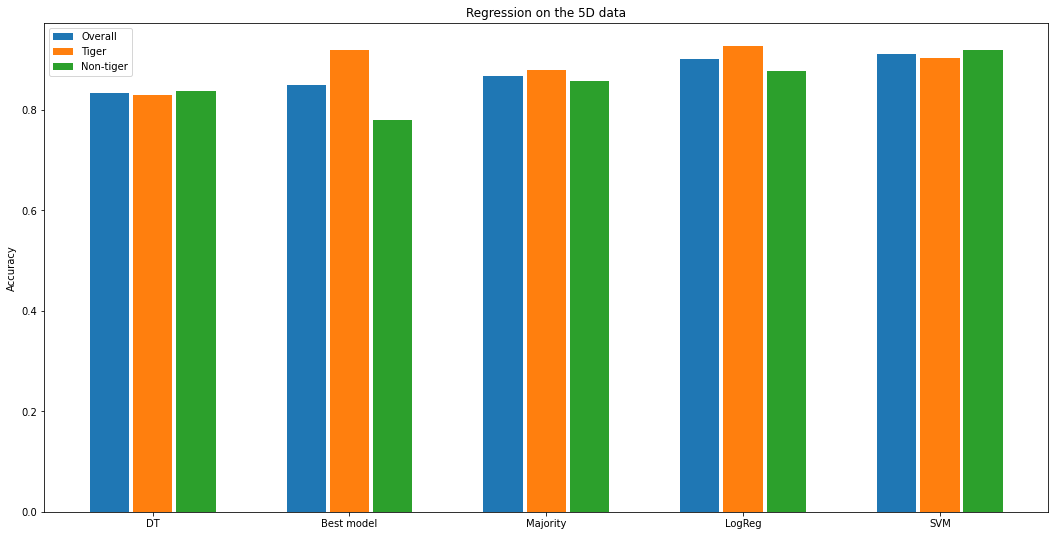

In [72]:
import matplotlib.pyplot as plt
labels = results.index


x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
fig, ax = plt.subplots(figsize=(18,9))
rects1 = ax.bar(x - 1.1*width, results['Overall Accuracy'], width, label='Overall')
rects2 = ax.bar(x, results['Tiger Accuracy'], width, label='Tiger')
rects3 = ax.bar(x + 1.1*width, results['Non-tiger Accuracy'], width, label='Non-tiger')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Regression on the 5D data')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()